# **A Deep Dive into Why GPUs Outpace CPUs**  A Hands-On Tutorial

FLOPS is commonly used to quantify the computational power of processors and other computing devices. It is an important metric for tasks that involve complex mathematical calculations, such as scientific simulations, artificial intelligence and machine learning algorithms. <p>

FLOPS stands for "Floating Point Operations Per Second" which means the number of floating-point calculations a computer system can perform in one second. The higher the FLOPS value, the faster the computer or processor can perform floating-point calculations, indicating better computational performance.
<p>
In this tutorial, let us use FLOPS as a metric to evaluate the performance of CPU versus GPU. We will begin by employing the DAXPY (Double-precision A*X plus Y) operation, a commonly used operation in numerical computing. This operation involves multiplying a scalar (A) with a vector (X) and adding the result to another vector (Y). We will calculate FLOPS to perform the DAXPY operation using both the CPU and GPU, respectively.
<p>
The DAXPY operation is executed using NumPy operations (A * X + Y). NumPy can leverage optimized implementations, and the actual computation may occur in optimized C or Fortran libraries. Therefore, a more effective way to compare speeds is by conducting matrix multiplications using TensorFlow. The second part of our code is designed to accomplish precisely this task. We will perform matrix multiplications of various-sized matrices and explore how the true advantage of GPUs lies in working with large matrices (datasets in general).



**Let us start by finding out the details of our current hadrware.**

In [ ]:
import psutil
import tensorflow as tf

# CPU Information
cpu_info = {
    "Physical Cores": psutil.cpu_count(logical=False),
    "Total Cores": psutil.cpu_count(logical=True),
    "CPU Frequency": psutil.cpu_freq().current,
    "CPU Usage": psutil.cpu_percent(interval=1),
}

print("CPU Information:")
for key, value in cpu_info.items():
    print(f"{key}: {value}")

# GPU Information
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if physical_devices:
    gpu_info = tf.config.experimental.get_device_details(physical_devices[0])
    print("\nGPU Information:")
    for key, value in gpu_info.items():
        print(f"{key}: {value}")
else:
    print("\nGPU not available on this machine.")


CPU Information:
Physical Cores: 1
Total Cores: 2
CPU Frequency: 2000.18
CPU Usage: 100.0

GPU Information:
compute_capability: (7, 5)
device_name: Tesla T4


At the time of this testing, the GPU offered by Colab is Tesla T4 <br><p>
**Specifications:** <br>
* Turing Tensor Cores. 320. <br>
* **NVIDIA CUDA cores. 2,560.** <br>
* **Single Precision Performance (FP32) 8.1 TFLOPS.**<br>
* Mixed Precision (FP16/FP32) 65 FP16 TFLOPS.<br>
* INT8 Precision. 130 INT8 TOPS.<br>
* INT4 Precision. 260 INT4 TOPS.<br>




**Calculating FLOPS for CPU and GPU using DAXPY**

In [ ]:
import numpy as np
import time
import tensorflow as tf

def perform_daxpy(array_size, use_gpu=False):
    if use_gpu:
        device = '/device:GPU:0'
    else:
        device = '/device:CPU:0'

    with tf.device(device):
        # Create NumPy arrays for vectors X, Y, and a scalar A
        A = 2.0  # Scalar
        X = np.random.rand(array_size)
        Y = np.random.rand(array_size)

        # Measure the time taken for the DAXPY operation
        start_time = time.time()
        result = A * X + Y
        end_time = time.time()

        # Calculate FLOPS
        elapsed_time = end_time - start_time
        flops = array_size / elapsed_time

        return flops


# Define the size of the array for the operation
array_size = 10**6  #System crashes for large arrays as they may exceed system memory.

# Perform DAXPY on CPU
cpu_flops = perform_daxpy(array_size, use_gpu=False)
print(f"CPU FLOPS: {cpu_flops:.2e}")

# Perform DAXPY on GPU (if available)
if tf.config.experimental.list_physical_devices('GPU'):
    gpu_flops = perform_daxpy(array_size, use_gpu=True)
    print(f"GPU FLOPS: {gpu_flops:.2e}")
    # Calculate percent difference
    percent_difference = abs((gpu_flops - cpu_flops) / cpu_flops) * 100
    print(f"GPU is {percent_difference:.2f}% faster than CPU.")
else:
    print("GPU not available on this machine.")



CPU FLOPS: 1.84e+08
GPU FLOPS: 2.85e+08
GPU is 54.98% faster than CPU.


We do not see a significant advantage of GPU over CPU. This is because DAXPY is not a suitable operation for this test. Moreover, increasing the array_size for this test beyond 10**6 (at the time of this test) demands additional RAM and crashes the system. Therefore, let us continue our CPU vs GPU speed test using matrix multiplication with the TensorFlow library.

**Testing CPU vs GPU speed using matrix multiplication**

Here, we will verify the GPU speed advantage over CPU for different matrix sizes. The relative efficiency of the GPU compared to the CPU can vary based on the computational demands of the specific task. <p>
In order to make sure we start with a common base line for each matrix multiplication task, we will clear the default graph and release the GPU memory. We will also disable the eager execution in TensorFlow for the matrix multiplication task. Please note that eager execution is a mode that allows operations to be executed immediately as they are called, instead of requiring them to be explicitly executed within a session. Eager execution is enabled by default in TensorFlow 2.x. By disabling eager execution, operations are added to a computation graph, and the graph is executed within a session.

In [ ]:
import numpy as np
import pandas as pd
import time
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

def perform_matmul(matrix_size, use_gpu=False):
    if use_gpu:
        device = '/device:GPU:0'
    else:
        device = '/device:CPU:0'

    with tf.device(device):
        # Reset default graph and clear GPU memory
        tf.compat.v1.reset_default_graph()

        # Create NumPy arrays for matrices A and B
        A = np.random.rand(matrix_size, matrix_size)
        B = np.random.rand(matrix_size, matrix_size)

        # Disable eager execution temporarily
        tf.config.experimental_run_functions_eagerly(False)

        # Measure the time taken for the matrix multiplication
        start_time = time.time()
        result = tf.matmul(A, B)
        end_time = time.time()

        # Enable eager execution again
        tf.config.experimental_run_functions_eagerly(True)

        # Calculate FLOPS
        elapsed_time = end_time - start_time
        flops = 2 * matrix_size**3 / elapsed_time

        # Convert FLOPS to TFLOPS
        tflops = flops / 1e12

        return tflops

# Matrix sizes to test
matrix_sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000,
                5000, 7500, 10000]

# Lists to store results
data = {'Matrix Size': [], 'GPU TFLOPS': [], 'CPU TFLOPS': [], 'Percentage Speedup': []}

# Loop through matrix sizes
for matrix_size in matrix_sizes:
    tflops_gpu = perform_matmul(matrix_size, use_gpu=True)
    tflops_cpu = perform_matmul(matrix_size, use_gpu=False)

    # Calculate percentage speedup
    percentage_speedup = ((tflops_gpu - tflops_cpu) / tflops_cpu) * 100

    # Store data in the dictionary
    data['Matrix Size'].append(matrix_size)
    data['GPU TFLOPS'].append(tflops_gpu)
    data['CPU TFLOPS'].append(tflops_cpu)
    data['Percentage Speedup'].append(percentage_speedup)

    # Print results for each matrix size
    print(f"Matrix Size: {matrix_size}, GPU TFLOPS: {tflops_gpu}, CPU TFLOPS: {tflops_cpu}")
    print(f"GPU is {percentage_speedup:.2f}% faster than CPU.\n")

# Create a DataFrame from the collected data
df = pd.DataFrame(data)



Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


Matrix Size: 100, GPU TFLOPS: 1.64290193636077e-05, CPU TFLOPS: 0.0008879652799830634
GPU is -98.15% faster than CPU.

Matrix Size: 200, GPU TFLOPS: 0.0005454630458990011, CPU TFLOPS: 0.007363272328286153
GPU is -92.59% faster than CPU.

Matrix Size: 300, GPU TFLOPS: 0.019264473590201583, CPU TFLOPS: 0.011549842733299337
GPU is 66.79% faster than CPU.

Matrix Size: 400, GPU TFLOPS: 0.0534040497363971, CPU TFLOPS: 0.012853949577417577
GPU is 315.47% faster than CPU.

Matrix Size: 500, GPU TFLOPS: 0.059976891837785276, CPU TFLOPS: 0.01263101088946709
GPU is 374.84% faster than CPU.

Matrix Size: 600, GPU TFLOPS: 0.11039659586912813, CPU TFLOPS: 0.016305709241111202
GPU is 577.04% faster than CPU.

Matrix Size: 700, GPU TFLOPS: 0.13078008017817372, CPU TFLOPS: 0.015063885658042156
GPU is 768.17% faster than CPU.

Matrix Size: 800, GPU TFLOPS: 0.17862948328065212, CPU TFLOPS: 0.014528627181424865
GPU is 1129.50% faster than CPU.

Matrix Size: 900, GPU TFLOPS: 0.14698462280975846, CPU TFLOP

How come CPU is faster than GPU for small matrix sizes? <br>
For small matrices, the computational advantage of the GPU may not outweigh the associated overhead and warm-up time. As the matrix size increases, the GPU's parallel processing capability becomes more effective

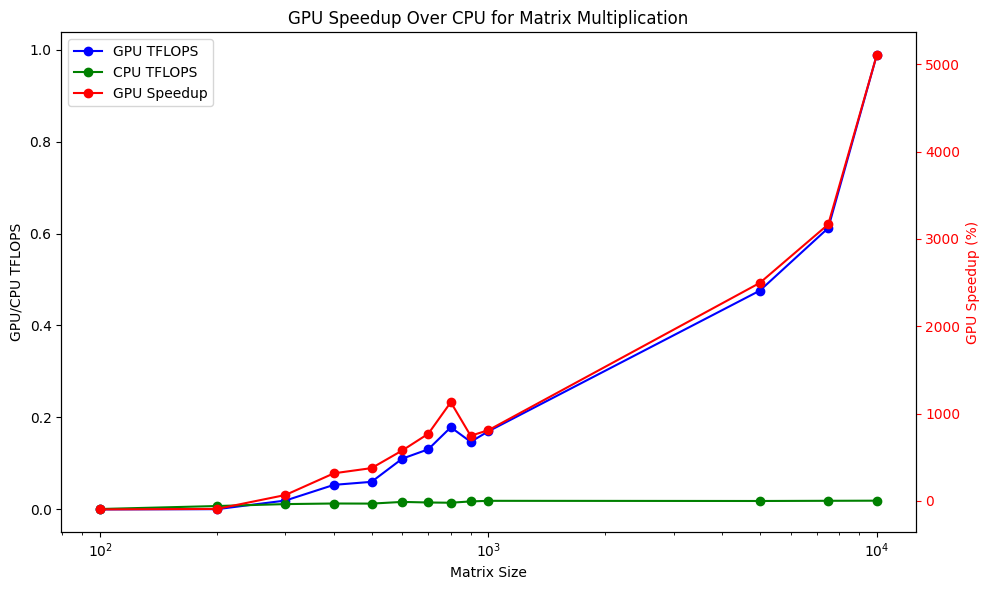

In [ ]:
# Plotting the results with CPU and GPU TFLOPS, and Percentage Speedup
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot GPU TFLOPS on the primary y-axis
gpu_tflops_line, = ax1.plot(df['Matrix Size'], df['GPU TFLOPS'], marker='o', linestyle='-', color='blue', label='GPU TFLOPS')
cpu_tflops_line, = ax1.plot(df['Matrix Size'], df['CPU TFLOPS'], marker='o', linestyle='-', color='green', label='CPU TFLOPS')
ax1.set_xlabel('Matrix Size')
ax1.set_ylabel('GPU/CPU TFLOPS', color='black')
ax1.tick_params('y', colors='black')

# Create a secondary y-axis for Percentage Speedup
ax2 = ax1.twinx()
speedup_line, = ax2.plot(df['Matrix Size'], df['Percentage Speedup'], marker='o', linestyle='-', color='red', label='GPU Speedup')
ax2.set_ylabel('GPU Speedup (%)', color='red')
ax2.tick_params('y', colors='red')

# Add legend
lines = [gpu_tflops_line, cpu_tflops_line, speedup_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

plt.xscale('log')  # Use a logarithmic scale for better visualization
plt.title('GPU Speedup Over CPU for Matrix Multiplication')
fig.tight_layout()
plt.show()

**Summary of our experiment:**
 <p>
 GPU is highly effective in handling larger and more computationally intensive tasks. On the other hand, the CPU's performance appears to plateau with the matrix size.

### Write an code for the follwoing  

You are a data scientist working at a company that develops image recognition systems. Your team has been tasked with building an image classification model to recognize handwritten digits from the MNIST dataset. The goal is to build a model that can classify digits (0-9) accurately and efficiently. The model should be trained both on a CPU and a GPU to compare the performance and determine the best hardware setup for deployment in production. You decide to use a Convolutional Neural Network (CNN) architecture for this task, as it is known to perform well with image data.

The model architecture consists of several layers designed for image classification tasks, such as recognizing digits from the MNIST dataset. The architecture begins with a 2D convolutional layer (Conv2D), which applies 32 filters of size 3x3 to the input image (28x28x1), followed by the ReLU activation function to introduce non-linearity. This is followed by a max-pooling layer (MaxPooling2D) with a pool size of 2x2, reducing the spatial dimensions of the feature maps while retaining important information. A second convolutional layer with 64 filters of size 3x3 is then applied, again using ReLU activation. Another max-pooling layer  (2x2 ) follows to further downsample the feature maps. The output of the convolutional layers is then flattened into a one-dimensional vector using the Flatten layer, which is fed into the fully connected dense layers. The first dense layer has 64 neurons with ReLU activation, allowing the model to learn complex representations, while the final dense layer has 10 neurons with a softmax activation function, providing probabilities for each of the 10 possible digit classes.


The training process is measured on both CPU and GPU, and you are also tracking the time it takes to train the model on each device.

In [1]:
#CPU

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import time

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1)).astype('float32') / 255
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1)).astype('float32') / 255

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Define the CNN model
def create_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

# Compile the model
model = create_cnn_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Function to train and evaluate the model
def train_and_evaluate(device):
    # Set the device (CPU or GPU)
    with tf.device(device):
        print(f"\nTraining on {device}...")
        start_time = time.time()

        # Train the model
        model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=1)

        # Evaluate the model
        test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
        print(f"Test accuracy on {device}: {test_acc:.4f}")

        # Print training time
        training_time = time.time() - start_time
        print(f"Training time on {device}: {training_time:.2f} seconds")

# Train and evaluate on CPU
train_and_evaluate('/cpu:0')

# Train and evaluate on GPU (if available)
if tf.config.list_physical_devices('GPU'):
    train_and_evaluate('/gpu:0')
else:
    print("GPU not available. Skipping GPU training.")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training on /cpu:0...
Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 47s 58ms/step - accuracy: 0.8610 - loss: 0.4589 - val_accuracy: 0.9804 - val_loss: 0.0701
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 49s 66ms/step - accuracy: 0.9800 - loss: 0.0661 - val_accuracy: 0.9838 - val_loss: 0.0555
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 75s 57ms/step - accuracy: 0.9864 - loss: 0.0434 - val_accuracy: 0.9858 - val_loss: 0.0496
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 44s 58ms/step - accuracy: 0.9892 - loss: 0.0352 - val_accuracy: 0.9877 - val_loss: 0.0423
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 47s 62ms/step - accuracy: 0.9918 - loss: 0.0256 - val_accuracy: 0.9869 - val_loss: 0.0420
Test accuracy on /cpu:0: 0.9890
Training time on /cpu:0: 301.03 seconds
GPU not available. Skipping GPU training.


In [1]:
#GPU

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import time

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1)).astype('float32') / 255
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1)).astype('float32') / 255

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Define the CNN model
def create_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

# Create and compile the model
model = create_cnn_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available. Training on GPU...")
    start_time = time.time()

    # Train the model
    model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=1)

    # Evaluate the model
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test accuracy: {test_acc:.4f}")

    # Print training time
    training_time = time.time() - start_time
    print(f"Training time on GPU: {training_time:.2f} seconds")
else:
    print("GPU not available. Please ensure TensorFlow is installed with GPU support.")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


GPU is available. Training on GPU...
Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8684 - loss: 0.4515 - val_accuracy: 0.9793 - val_loss: 0.0723
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9806 - loss: 0.0640 - val_accuracy: 0.9828 - val_loss: 0.0565
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9865 - loss: 0.0430 - val_accuracy: 0.9849 - val_loss: 0.0489
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9894 - loss: 0.0330 - val_accuracy: 0.9867 - val_loss: 0.0484
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9917 - loss: 0.0266 - val_accuracy: 0.9883 - val_loss: 0.0376
Test accuracy: 0.9893
Training time on GPU: 26.40 seconds
